In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.style.use('default')  # Changed from 'seaborn-v0_8' which is deprecated
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("E-commerce Customer Segmentation Analysis")
print("=" * 50)

E-commerce Customer Segmentation Analysis


In [3]:
def load_cleaned_data():
    """
    Load cleaned datasets from the data cleaning pipeline
    """
    try:
        data = {
            'orders': pd.read_csv('data/cleaned/cleaned_orders.csv'),
            'order_items': pd.read_csv('data/cleaned/cleaned_order_items.csv'),
            'order_payments': pd.read_csv('data/cleaned/cleaned_order_payments.csv'),
            'order_reviews': pd.read_csv('data/cleaned/cleaned_order_reviews.csv'),
            'customers': pd.read_csv('data/cleaned/cleaned_customers.csv'),
            'products': pd.read_csv('data/cleaned/cleaned_products.csv')
        }
        
        # Convert datetime columns
        datetime_columns = {
            'orders': ['order_purchase_timestamp', 'order_approved_at', 
                      'order_delivered_carrier_date', 'order_delivered_customer_date'],
            'order_reviews': ['review_creation_date', 'review_answer_timestamp']
        }
        
        for dataset, columns in datetime_columns.items():
            if dataset in data:
                for col in columns:
                    if col in data[dataset].columns:
                        data[dataset][col] = pd.to_datetime(data[dataset][col])
        
        print("✓ Cleaned data loaded successfully")
        for name, df in data.items():
            print(f"  {name}: {df.shape}")
        
        return data
    
    except FileNotFoundError as e:
        print(f"Error loading cleaned data: {e}")
        print("Please run 02_data_cleaning.ipynb first to generate cleaned datasets")
        return None

# Load cleaned data
data = load_cleaned_data()

✓ Cleaned data loaded successfully
  orders: (96461, 13)
  order_items: (112650, 8)
  order_payments: (103886, 5)
  order_reviews: (98673, 10)
  customers: (99441, 5)
  products: (32951, 10)


In [4]:
def create_customer_master_table(data):
    """
    Create a comprehensive customer master table with RFM and behavioral features
    """
    print("\nCreating Customer Master Table...")
    
    # Start with customers table
    customer_master = data['customers'].copy()
    
    # Calculate the analysis date (last order date + 1 day)
    analysis_date = data['orders']['order_purchase_timestamp'].max() + timedelta(days=1)
    print(f"Analysis date: {analysis_date.date()}")
    
    # ============ MONETARY FEATURES ============
    # Calculate total spent per customer
    order_values = (data['order_items']
                   .groupby('order_id')
                   .agg({'total_item_value': 'sum'})
                   .reset_index())
    
    customer_orders = data['orders'][['order_id', 'customer_id']].merge(
        order_values, on='order_id', how='left')
    
    monetary_features = (customer_orders
                        .groupby('customer_id')
                        .agg({
                            'total_item_value': ['sum', 'mean', 'std', 'count']
                        })
                        .round(2))
    
    monetary_features.columns = ['total_spent', 'avg_order_value', 'std_order_value', 'total_orders']
    monetary_features['std_order_value'] = monetary_features['std_order_value'].fillna(0)
    
    # ============ FREQUENCY FEATURES ============
    frequency_features = (data['orders']
                         .groupby('customer_id')
                         .agg({
                             'order_id': 'count',
                             'order_purchase_timestamp': ['min', 'max']
                         }))
    
    frequency_features.columns = ['frequency', 'first_purchase', 'last_purchase']
    
    # Calculate customer lifetime in days
    frequency_features['customer_lifetime_days'] = (
        frequency_features['last_purchase'] - frequency_features['first_purchase']
    ).dt.days
    frequency_features['customer_lifetime_days'] = frequency_features['customer_lifetime_days'].fillna(0)
    
    # Calculate purchase frequency (orders per month)
    frequency_features['purchase_frequency_monthly'] = np.where(
        frequency_features['customer_lifetime_days'] > 0,
        frequency_features['frequency'] / (frequency_features['customer_lifetime_days'] / 30),
        frequency_features['frequency']  # For customers with single purchase
    ).round(2)
    
    # ============ RECENCY FEATURES ============
    recency_features = (data['orders']
                       .groupby('customer_id')
                       .agg({'order_purchase_timestamp': 'max'})
                       .reset_index())
    
    recency_features['recency_days'] = (
        analysis_date - recency_features['order_purchase_timestamp']
    ).dt.days
    
    recency_features = recency_features[['customer_id', 'recency_days']].set_index('customer_id')
    
    # ============ BEHAVIORAL FEATURES ============
    # Product diversity (number of unique products purchased)
    product_diversity = (data['order_items']
                        .merge(data['orders'][['order_id', 'customer_id']], on='order_id')
                        .groupby('customer_id')
                        .agg({
                            'product_id': 'nunique',
                            'order_item_id': 'count'  # Changed from 'sum' to 'count' for total items
                        }))
    product_diversity.columns = ['unique_products', 'total_items']
    
    # Payment behavior
    payment_behavior = (data['order_payments']
                       .merge(data['orders'][['order_id', 'customer_id']], on='order_id')
                       .groupby('customer_id')
                       .agg({
                           'payment_type': lambda x: x.mode().iloc[0],
                           'payment_installments': 'mean',
                           'payment_value': 'sum'
                       }))
    payment_behavior.columns = ['preferred_payment_type', 'avg_installments', 'total_payment_value']
    payment_behavior['avg_installments'] = payment_behavior['avg_installments'].round(1)
    
    # Review behavior (with null checks)
    if 'review_comment_message' in data['order_reviews'].columns:
        review_behavior = (data['order_reviews']
                          .merge(data['orders'][['order_id', 'customer_id']], on='order_id')
                          .groupby('customer_id')
                          .agg({
                              'review_score': ['count', 'mean'],
                              'review_comment_message': lambda x: (x.notna() & (x != '') & (x != 'No Comment')).sum()
                          }))
    else:
        # Fallback if column doesn't exist
        review_behavior = (data['order_reviews']
                          .merge(data['orders'][['order_id', 'customer_id']], on='order_id')
                          .groupby('customer_id')
                          .agg({
                              'review_score': ['count', 'mean']
                          }))
        review_behavior[('review_comment_message', '<lambda>')] = 0
    
    review_behavior.columns = ['reviews_given', 'avg_review_score', 'reviews_with_comments']
    review_behavior['avg_review_score'] = review_behavior['avg_review_score'].round(2)
    
    # Calculate review rate (percentage of orders reviewed)
    review_behavior = review_behavior.merge(monetary_features[['total_orders']], 
                                          left_index=True, right_index=True, how='left')
    review_behavior['review_rate'] = np.where(
        review_behavior['total_orders'] > 0,
        (review_behavior['reviews_given'] / review_behavior['total_orders'] * 100).round(2),
        0
    )
    review_behavior = review_behavior.drop('total_orders', axis=1)
    
    # ============ MERGE ALL FEATURES ============
    customer_master = customer_master.set_index('customer_id')
    
    # Merge all feature tables
    feature_tables = [monetary_features, frequency_features, recency_features, 
                     product_diversity, payment_behavior, review_behavior]
    
    for features in feature_tables:
        customer_master = customer_master.merge(features, left_index=True, right_index=True, how='left')
    
    # Fill NaN values for customers with no orders (edge case)
    numerical_cols = customer_master.select_dtypes(include=[np.number]).columns
    customer_master[numerical_cols] = customer_master[numerical_cols].fillna(0)
    
    customer_master['preferred_payment_type'] = customer_master['preferred_payment_type'].fillna('unknown')
    
    print(f"✓ Customer master table created with shape: {customer_master.shape}")
    print(f"✓ Features included: {list(customer_master.columns)}")
    
    return customer_master, analysis_date

# Create customer master table
customer_master, analysis_date = create_customer_master_table(data)

# Display basic statistics
print("\nCustomer Master Table - Basic Statistics:")
print(customer_master.describe())



Creating Customer Master Table...
Analysis date: 2018-08-30
✓ Customer master table created with shape: (99441, 23)
✓ Features included: ['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'total_spent', 'avg_order_value', 'std_order_value', 'total_orders', 'frequency', 'first_purchase', 'last_purchase', 'customer_lifetime_days', 'purchase_frequency_monthly', 'recency_days', 'unique_products', 'total_items', 'preferred_payment_type', 'avg_installments', 'total_payment_value', 'reviews_given', 'avg_review_score', 'reviews_with_comments', 'review_rate']

Customer Master Table - Basic Statistics:
       customer_zip_code_prefix   total_spent  avg_order_value  \
count              99441.000000  99441.000000     99441.000000   
mean               35137.474583    128.487353       128.487353   
min                 1003.000000      0.000000         0.000000   
25%                11347.000000     58.050000        58.050000   
50%                24416.000000   

In [5]:
def create_rfm_segments(df):
    """
    Create RFM segments using quintile-based scoring (FIXED)
    """
    print("\nCreating RFM Segments...")
    
    rfm_df = df[['recency_days', 'frequency', 'total_spent']].copy()
    rfm_df.columns = ['Recency', 'Frequency', 'Monetary']
    
    # Handle edge case where all values are the same
    try:
        # Create RFM scores (1-5, where 5 is best for F and M, 1 is best for R)
        rfm_df['R_Score'] = pd.qcut(rfm_df['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop')
        rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
        rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1,2,3,4,5], duplicates='drop')
    except ValueError as e:
        print(f"Warning: Quintile creation failed, using ranking approach: {e}")
        # Fallback to ranking-based approach
        rfm_df['R_Score'] = pd.cut(rfm_df['Recency'], 5, labels=[5,4,3,2,1])
        rfm_df['F_Score'] = pd.cut(rfm_df['Frequency'], 5, labels=[1,2,3,4,5])
        rfm_df['M_Score'] = pd.cut(rfm_df['Monetary'], 5, labels=[1,2,3,4,5])
    
    # Convert to numeric, handling any NaN values
    rfm_df['R_Score'] = pd.to_numeric(rfm_df['R_Score'], errors='coerce').fillna(3).astype(int)
    rfm_df['F_Score'] = pd.to_numeric(rfm_df['F_Score'], errors='coerce').fillna(3).astype(int)
    rfm_df['M_Score'] = pd.to_numeric(rfm_df['M_Score'], errors='coerce').fillna(3).astype(int)
    
    # Create RFM combined score
    rfm_df['RFM_Score'] = (rfm_df['R_Score'].astype(str) + 
                          rfm_df['F_Score'].astype(str) + 
                          rfm_df['M_Score'].astype(str))
    
    # Simplified RFM segmentation logic (FIXED)
    def rfm_segment(row):
        r, f, m = row['R_Score'], row['F_Score'], row['M_Score']
        
        # Champions: High value, high frequency, recent
        if r >= 4 and f >= 4 and m >= 4:
            return 'Champions'
        # Loyal Customers: High frequency, good value
        elif f >= 4 and m >= 3:
            return 'Loyal Customers'
        # Potential Loyalists: Recent, good frequency or value
        elif r >= 3 and (f >= 3 or m >= 3):
            return 'Potential Loyalists'
        # New Customers: Recent but low frequency
        elif r >= 4 and f <= 2:
            return 'New Customers'
        # At Risk: Good value but not recent
        elif r <= 2 and (f >= 3 or m >= 4):
            return 'At Risk'
        # Big Spenders: High value regardless of recency/frequency
        elif m >= 4:
            return 'Big Spenders'
        # About to Sleep: Moderate recency, low engagement
        elif r == 3 and f <= 2:
            return 'About to Sleep'
        # Can't Lose Them: High value but very low recency
        elif r <= 1 and m >= 4:
            return 'Cannot Lose Them'
        # Lost: Low on all dimensions
        elif r <= 2 and f <= 2 and m <= 2:
            return 'Lost'
        else:
            return 'Others'
    
    rfm_df['Customer_Segment'] = rfm_df.apply(rfm_segment, axis=1)
    
    print("✓ RFM segments created")
    print("\nRFM Segment Distribution:")
    segment_counts = rfm_df['Customer_Segment'].value_counts()
    print(segment_counts)
    print(f"\nPercentage Distribution:")
    print((segment_counts / len(rfm_df) * 100).round(2))
    
    return rfm_df

# Create RFM segments
rfm_data = create_rfm_segments(customer_master)


Creating RFM Segments...
✓ RFM segments created

RFM Segment Distribution:
Customer_Segment
Potential Loyalists    34135
At Risk                20660
Loyal Customers        18206
New Customers           8152
Champions               6407
Lost                    5969
Others                  3005
About to Sleep          2907
Name: count, dtype: int64

Percentage Distribution:
Customer_Segment
Potential Loyalists    34.33
At Risk                20.78
Loyal Customers        18.31
New Customers           8.20
Champions               6.44
Lost                    6.00
Others                  3.02
About to Sleep          2.92
Name: count, dtype: float64



Preparing features for clustering...
Using features: ['recency_days', 'frequency', 'total_spent', 'avg_order_value', 'customer_lifetime_days', 'purchase_frequency_monthly', 'unique_products', 'total_items', 'avg_installments', 'avg_review_score', 'review_rate']
✓ Features prepared. Shape: (99441, 11)
✓ Features: ['frequency', 'avg_order_value', 'purchase_frequency_monthly', 'unique_products', 'total_items', 'avg_installments', 'avg_review_score', 'review_rate', 'recency_days_log', 'total_spent_log', 'customer_lifetime_days_log']

Finding optimal number of clusters...


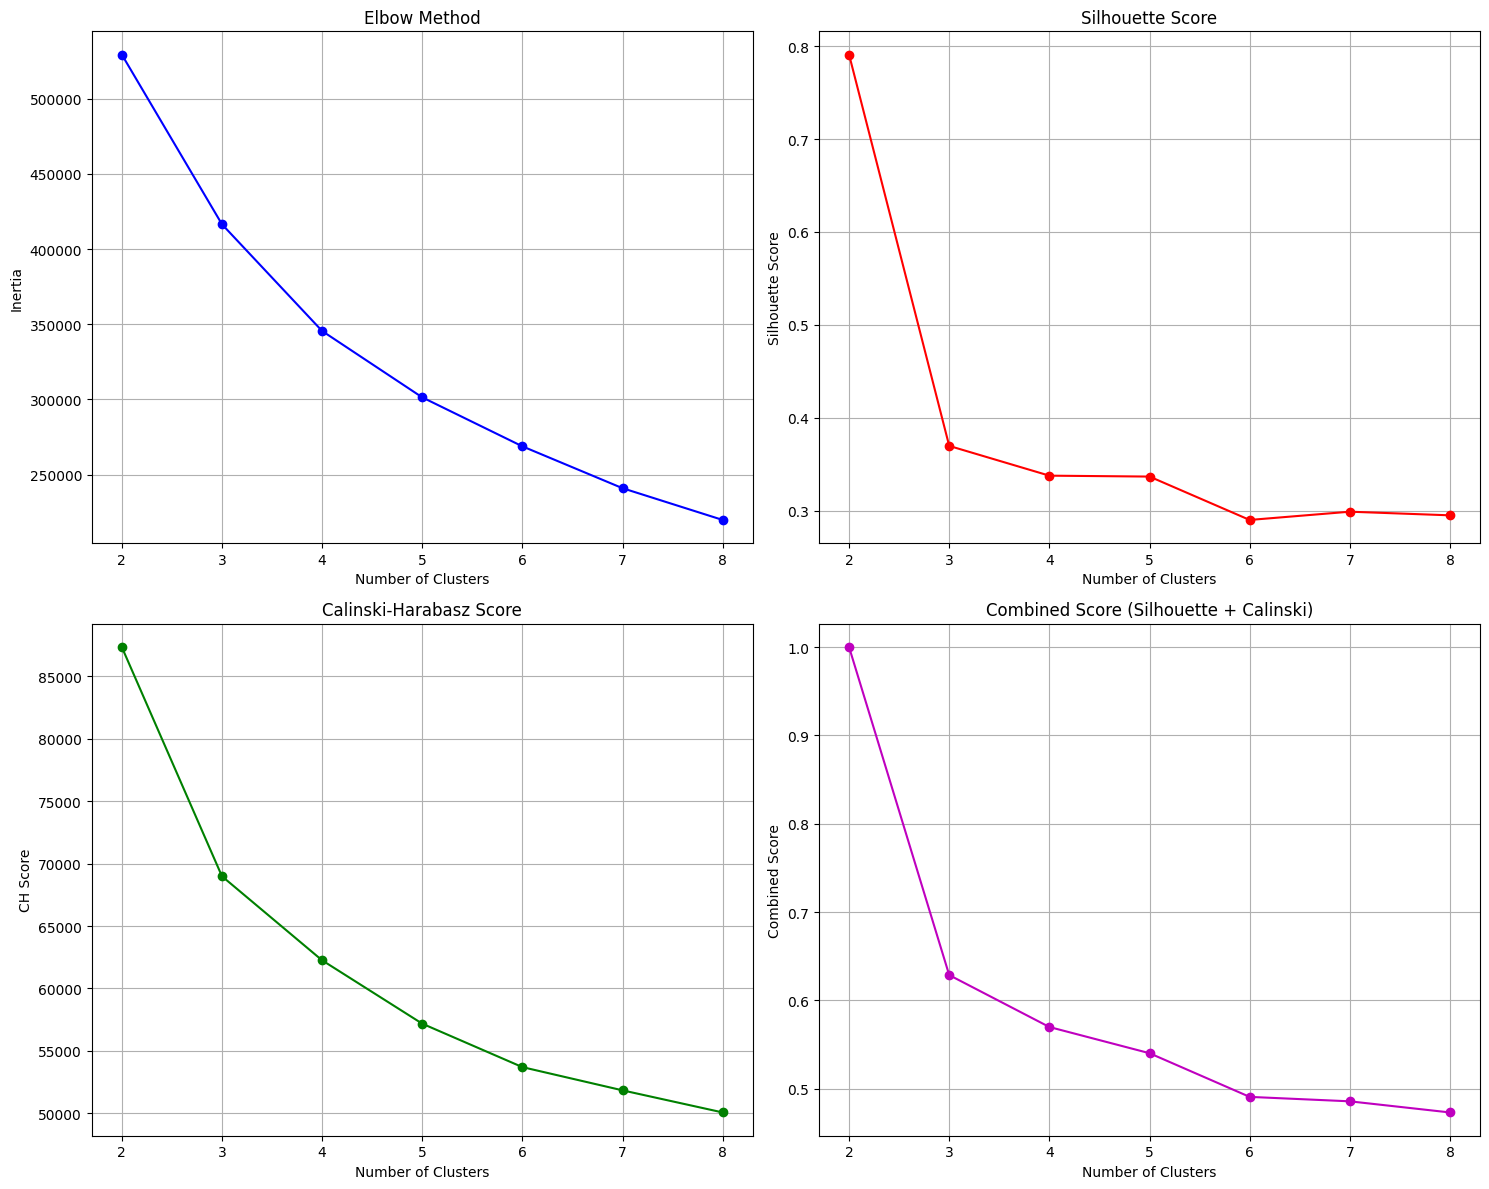

✓ Optimal number of clusters: 2

Performing K-means clustering with 2 clusters...
✓ Silhouette Score: 0.791
✓ Calinski-Harabasz Score: 87348.698


In [13]:
def prepare_clustering_features(df):
    """
    Prepare features for clustering analysis
    """
    print("\nPreparing features for clustering...")
    
    # Select features for clustering (only those that exist)
    potential_features = [
        'recency_days', 'frequency', 'total_spent', 'avg_order_value',
        'customer_lifetime_days', 'purchase_frequency_monthly',
        'unique_products', 'total_items', 'avg_installments',
        'avg_review_score', 'review_rate'
    ]
    
    # Only include features that exist in the dataframe
    clustering_features = [f for f in potential_features if f in df.columns]
    print(f"Using features: {clustering_features}")
    
    cluster_df = df[clustering_features].copy()
    
    # Handle any remaining missing values
    cluster_df = cluster_df.fillna(cluster_df.median())
    
    # Log transform skewed features (with safety check)
    skewed_features = ['recency_days', 'total_spent', 'customer_lifetime_days']
    for feature in skewed_features:
        if feature in cluster_df.columns:
            # Add small constant to handle zeros
            cluster_df[f'{feature}_log'] = np.log1p(cluster_df[feature])
            cluster_df = cluster_df.drop(feature, axis=1)
    
    # Remove any infinite values
    cluster_df = cluster_df.replace([np.inf, -np.inf], np.nan)
    cluster_df = cluster_df.fillna(cluster_df.median())
    
    # Standardize features
    scaler = StandardScaler()
    cluster_df_scaled = pd.DataFrame(
        scaler.fit_transform(cluster_df),
        columns=cluster_df.columns,
        index=cluster_df.index
    )
    
    print(f"✓ Features prepared. Shape: {cluster_df_scaled.shape}")
    print(f"✓ Features: {list(cluster_df_scaled.columns)}")
    
    return cluster_df_scaled, scaler, cluster_df

def find_optimal_clusters(data, max_clusters=8):  # Reduced max clusters
    """
    Find optimal number of clusters using multiple methods
    """
    print("\nFinding optimal number of clusters...")
    
    # Calculate metrics for different cluster numbers
    cluster_range = range(2, min(max_clusters + 1, len(data) // 10))  # Ensure reasonable range
    inertias = []
    silhouette_scores = []
    calinski_scores = []
    
    for n_clusters in cluster_range:
        try:
            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(data)
            
            inertias.append(kmeans.inertia_)
            silhouette_scores.append(silhouette_score(data, cluster_labels))
            calinski_scores.append(calinski_harabasz_score(data, cluster_labels))
        except Exception as e:
            print(f"Error with {n_clusters} clusters: {e}")
            continue
    
    if not inertias:
        print("Warning: Could not compute clustering metrics. Using default 4 clusters.")
        return 4, [], [], []
    
    # Plot evaluation metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Elbow method
    axes[0, 0].plot(cluster_range[:len(inertias)], inertias, 'bo-')
    axes[0, 0].set_title('Elbow Method')
    axes[0, 0].set_xlabel('Number of Clusters')
    axes[0, 0].set_ylabel('Inertia')
    axes[0, 0].grid(True)
    
    # Silhouette score
    axes[0, 1].plot(cluster_range[:len(silhouette_scores)], silhouette_scores, 'ro-')
    axes[0, 1].set_title('Silhouette Score')
    axes[0, 1].set_xlabel('Number of Clusters')
    axes[0, 1].set_ylabel('Silhouette Score')
    axes[0, 1].grid(True)
    
    # Calinski-Harabasz score
    axes[1, 0].plot(cluster_range[:len(calinski_scores)], calinski_scores, 'go-')
    axes[1, 0].set_title('Calinski-Harabasz Score')
    axes[1, 0].set_xlabel('Number of Clusters')
    axes[1, 0].set_ylabel('CH Score')
    axes[1, 0].grid(True)
    
    # Combined scores (normalized)
    if silhouette_scores and calinski_scores:
        normalized_silhouette = np.array(silhouette_scores) / max(silhouette_scores)
        normalized_calinski = np.array(calinski_scores) / max(calinski_scores)
        combined_score = (normalized_silhouette + normalized_calinski) / 2
        
        axes[1, 1].plot(cluster_range[:len(combined_score)], combined_score, 'mo-')
        axes[1, 1].set_title('Combined Score (Silhouette + Calinski)')
        axes[1, 1].set_xlabel('Number of Clusters')
        axes[1, 1].set_ylabel('Combined Score')
        axes[1, 1].grid(True)
        
        # Find optimal number of clusters
        optimal_k = cluster_range[np.argmax(combined_score)]
    else:
        optimal_k = 4  # Default fallback
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Optimal number of clusters: {optimal_k}")
    
    return optimal_k, inertias, silhouette_scores, calinski_scores

def perform_kmeans_clustering(data, n_clusters):
    """
    Perform K-means clustering
    """
    print(f"\nPerforming K-means clustering with {n_clusters} clusters...")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(data)
    
    # Calculate metrics
    silhouette_avg = silhouette_score(data, cluster_labels)
    calinski_score = calinski_harabasz_score(data, cluster_labels)
    
    print(f"✓ Silhouette Score: {silhouette_avg:.3f}")
    print(f"✓ Calinski-Harabasz Score: {calinski_score:.3f}")
    
    return kmeans, cluster_labels

# Prepare clustering data
cluster_features, feature_scaler, original_features = prepare_clustering_features(customer_master)

# Find optimal clusters
optimal_k, inertias, sil_scores, cal_scores = find_optimal_clusters(cluster_features)

# Perform K-means clustering
kmeans_model, cluster_labels = perform_kmeans_clustering(cluster_features, optimal_k)

# Add cluster labels to customer master
customer_master['ML_Cluster'] = cluster_labels
customer_master['RFM_Segment'] = rfm_data['Customer_Segment']


Analyzing ML_Cluster clusters...

Cluster Size Distribution:
  Cluster 0: 96,461 customers (97.0%)
  Cluster 1: 2,980 customers (3.0%)

Cluster Profiles (Mean values):
            recency_days  frequency  total_spent  avg_order_value  \
ML_Cluster                                                          
0                  240.1        1.0       132.46           132.46   
1                    0.0        0.0         0.00             0.00   

            customer_lifetime_days  unique_products  avg_review_score  
ML_Cluster                                                             
0                              0.0             1.04              4.13  
1                              0.0             0.00              0.00  

Creating cluster visualizations...


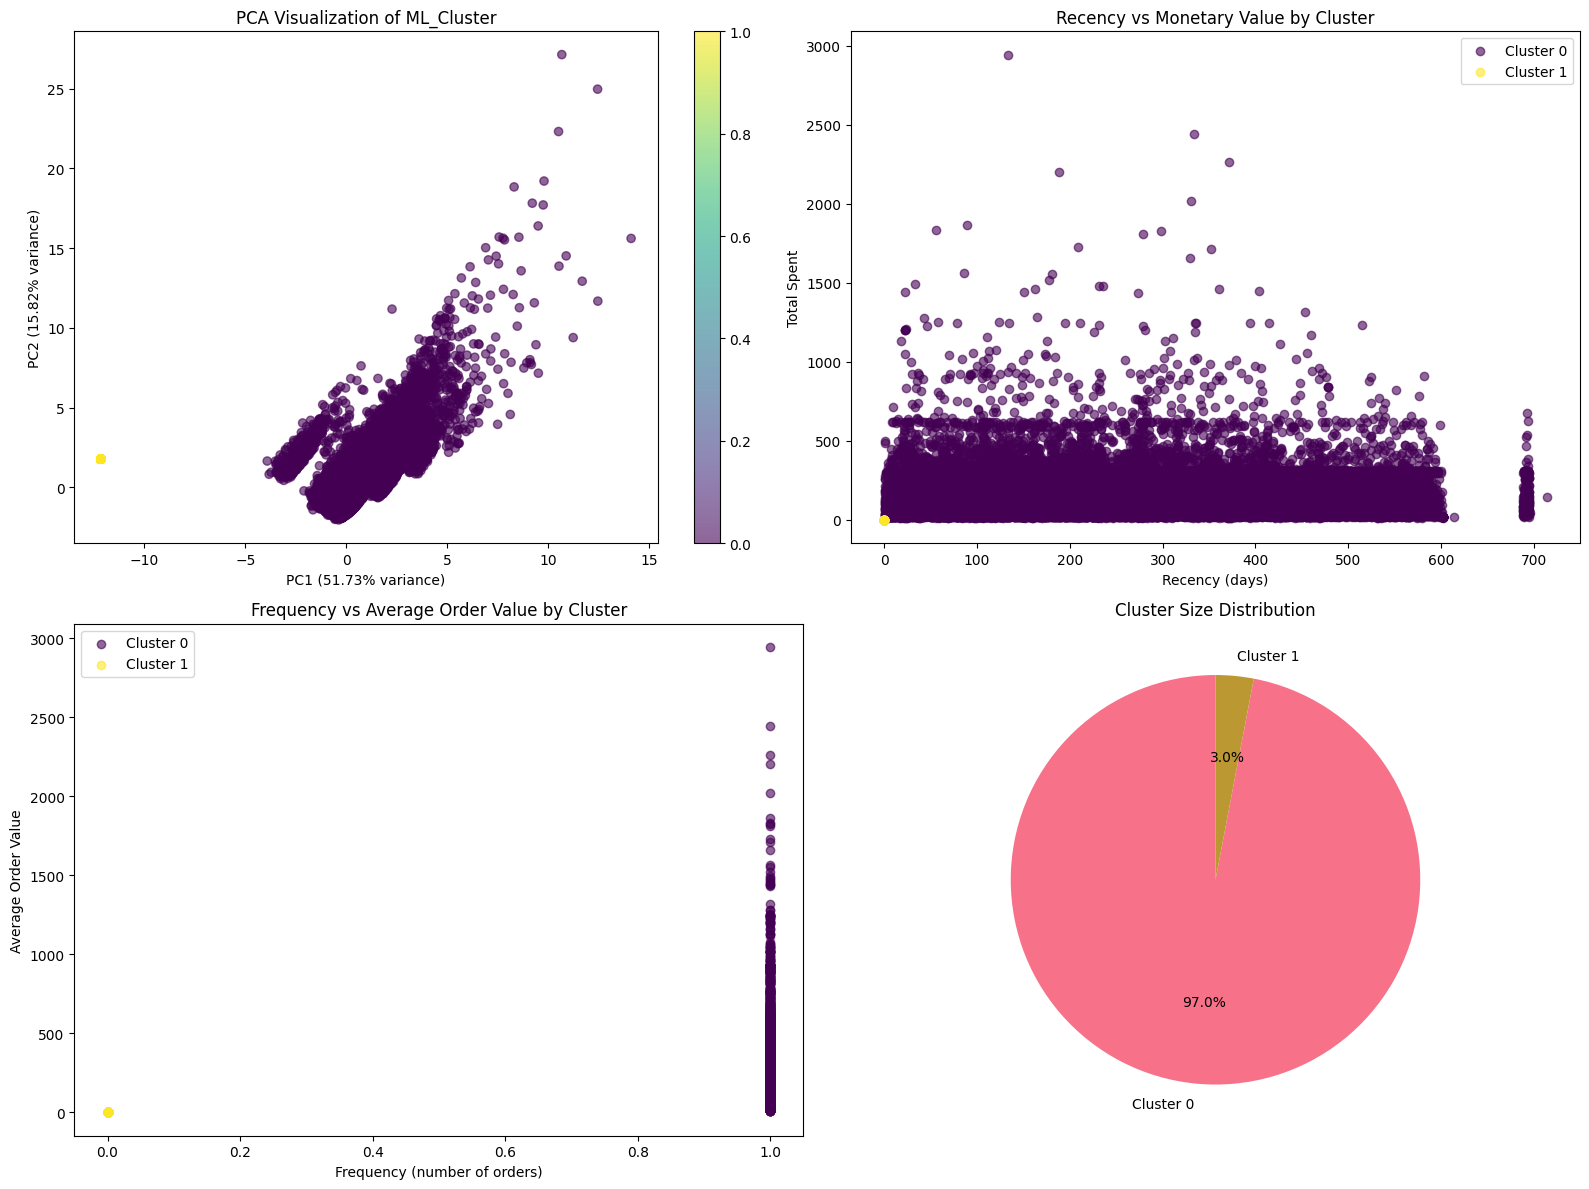


Generating Business Recommendations...

CLUSTER 0: Regular Customers
Size: 96,461 customers (97.0%)
Key Characteristics:
  • Average days since last purchase: 240
  • Average number of orders: 1.0
  • Average total spent: $132.46
  • Average order value: $132.46
  • Average unique products: 1.0

Recommended Strategies:
  1. Focus on retention with regular engagement
  2. Offer moderate discounts and promotions
  3. Encourage frequency with subscription models
  4. Implement basic loyalty program

CLUSTER 1: New/Potential Customers
Size: 2,980 customers (3.0%)
Key Characteristics:
  • Average days since last purchase: 0
  • Average number of orders: 0.0
  • Average total spent: $0.00
  • Average order value: $0.00
  • Average unique products: 0.0

Recommended Strategies:
  1. Create onboarding email sequences
  2. Offer first-purchase incentives
  3. Implement referral programs
  4. Focus on product education and value demonstration


In [16]:
def analyze_clusters(df, cluster_col='ML_Cluster'):
    """
    Comprehensive cluster analysis and profiling
    """
    print(f"\nAnalyzing {cluster_col} clusters...")
    
    # Cluster size distribution
    cluster_sizes = df[cluster_col].value_counts().sort_index()
    print(f"\nCluster Size Distribution:")
    for cluster, size in cluster_sizes.items():
        percentage = (size / len(df)) * 100
        print(f"  Cluster {cluster}: {size:,} customers ({percentage:.1f}%)")
    
    # Statistical profile of each cluster
    numerical_features = [
        'recency_days', 'frequency', 'total_spent', 'avg_order_value',
        'customer_lifetime_days', 'unique_products', 'avg_review_score'
    ]
    
    # Only include features that exist
    available_features = [f for f in numerical_features if f in df.columns]
    
    cluster_profiles = df.groupby(cluster_col)[available_features].agg(['mean', 'median']).round(2)
    
    print(f"\nCluster Profiles (Mean values):")
    print(cluster_profiles.xs('mean', level=1, axis=1))
    
    return cluster_profiles, cluster_sizes

def create_cluster_visualizations(df, features_scaled, cluster_col='ML_Cluster'):
    """
    Create comprehensive cluster visualizations
    """
    print(f"\nCreating cluster visualizations...")
    
    # 1. PCA visualization
    pca = PCA(n_components=2, random_state=42)
    pca_result = pca.fit_transform(features_scaled)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # PCA plot
    scatter = axes[0, 0].scatter(pca_result[:, 0], pca_result[:, 1], 
                                c=df[cluster_col], cmap='viridis', alpha=0.6)
    axes[0, 0].set_title(f'PCA Visualization of {cluster_col}')
    axes[0, 0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[0, 0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.colorbar(scatter, ax=axes[0, 0])
    
    # RFM scatter plots
    clusters = sorted(df[cluster_col].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(clusters)))
    
    for i, cluster in enumerate(clusters):
        cluster_data = df[df[cluster_col] == cluster]
        axes[0, 1].scatter(cluster_data['recency_days'], cluster_data['total_spent'], 
                          alpha=0.6, label=f'Cluster {cluster}', color=colors[i])
    
    axes[0, 1].set_title('Recency vs Monetary Value by Cluster')
    axes[0, 1].set_xlabel('Recency (days)')
    axes[0, 1].set_ylabel('Total Spent')
    axes[0, 1].legend()
    
    # Frequency vs Average Order Value
    for i, cluster in enumerate(clusters):
        cluster_data = df[df[cluster_col] == cluster]
        axes[1, 0].scatter(cluster_data['frequency'], cluster_data['avg_order_value'], 
                          alpha=0.6, label=f'Cluster {cluster}', color=colors[i])
    
    axes[1, 0].set_title('Frequency vs Average Order Value by Cluster')
    axes[1, 0].set_xlabel('Frequency (number of orders)')
    axes[1, 0].set_ylabel('Average Order Value')
    axes[1, 0].legend()
    
    # Cluster size distribution
    cluster_sizes = df[cluster_col].value_counts().sort_index()
    axes[1, 1].pie(cluster_sizes.values, labels=[f'Cluster {i}' for i in cluster_sizes.index], 
                   autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Cluster Size Distribution')
    
    plt.tight_layout()
    plt.show()
    
    return pca_result, pca

def create_business_recommendations(df, cluster_profiles):
    """
    Generate business recommendations for each cluster
    """
    print("\nGenerating Business Recommendations...")
    
    recommendations = {}
    
    for cluster in sorted(df['ML_Cluster'].unique()):
        cluster_data = df[df['ML_Cluster'] == cluster]
        
        # Get profile safely
        try:
            profile = cluster_profiles.xs('mean', level=1, axis=1).loc[cluster]
        except:
            print(f"Warning: Could not get profile for cluster {cluster}")
            continue
        
        # Analyze cluster characteristics
        avg_recency = profile.get('recency_days', 0)
        avg_frequency = profile.get('frequency', 0)
        avg_monetary = profile.get('total_spent', 0)
        avg_order_value = profile.get('avg_order_value', 0)
        avg_products = profile.get('unique_products', 0)
        
        # Generate recommendations based on characteristics
        if avg_monetary > df['total_spent'].quantile(0.75) and avg_frequency > df['frequency'].quantile(0.75):
            segment_name = "VIP Customers"
            strategies = [
                "Implement exclusive VIP program with premium benefits",
                "Offer early access to new products and sales",
                "Provide dedicated customer service line",
                "Create personalized product recommendations"
            ]
        elif avg_recency > df['recency_days'].quantile(0.75):
            segment_name = "At-Risk Customers"
            strategies = [
                "Launch re-engagement email campaigns",
                "Offer win-back discounts and incentives",
                "Conduct customer satisfaction surveys",
                "Implement retargeting advertising campaigns"
            ]
        elif avg_frequency < df['frequency'].quantile(0.25) and avg_recency < df['recency_days'].quantile(0.5):
            segment_name = "New/Potential Customers"
            strategies = [
                "Create onboarding email sequences",
                "Offer first-purchase incentives",
                "Implement referral programs",
                "Focus on product education and value demonstration"
            ]
        elif avg_order_value > df['avg_order_value'].quantile(0.75):
            segment_name = "High-Value Customers"
            strategies = [
                "Offer bundle deals and cross-selling opportunities",
                "Implement loyalty point multipliers",
                "Provide free shipping and premium services",
                "Create targeted upselling campaigns"
            ]
        else:
            segment_name = "Regular Customers"
            strategies = [
                "Focus on retention with regular engagement",
                "Offer moderate discounts and promotions",
                "Encourage frequency with subscription models",
                "Implement basic loyalty program"
            ]
        
        recommendations[cluster] = {
            'name': segment_name,
            'size': len(cluster_data),
            'percentage': len(cluster_data) / len(df) * 100,
            'characteristics': {
                'avg_recency_days': avg_recency,
                'avg_frequency': avg_frequency,
                'avg_total_spent': avg_monetary,
                'avg_order_value': avg_order_value,
                'avg_unique_products': avg_products
            },
            'strategies': strategies
        }
    
    # Print recommendations
    for cluster, rec in recommendations.items():
        print(f"\n{'='*50}")
        print(f"CLUSTER {cluster}: {rec['name']}")
        print(f"Size: {rec['size']:,} customers ({rec['percentage']:.1f}%)")
        print(f"{'='*50}")
        print("Key Characteristics:")
        chars = rec['characteristics']
        print(f"  • Average days since last purchase: {chars['avg_recency_days']:.0f}")
        print(f"  • Average number of orders: {chars['avg_frequency']:.1f}")
        print(f"  • Average total spent: ${chars['avg_total_spent']:.2f}")
        print(f"  • Average order value: ${chars['avg_order_value']:.2f}")
        print(f"  • Average unique products: {chars['avg_unique_products']:.1f}")
        print("\nRecommended Strategies:")
        for i, strategy in enumerate(rec['strategies'], 1):
            print(f"  {i}. {strategy}")
    
    return recommendations

# Analyze clusters
cluster_profiles, cluster_sizes = analyze_clusters(customer_master)

# Create visualizations
pca_result, pca_model = create_cluster_visualizations(customer_master, cluster_features)

# Generate business recommendations
business_recommendations = create_business_recommendations(customer_master, cluster_profiles)


Comparing RFM vs ML Clustering approaches...
Cross-tabulation of RFM Segments vs ML Clusters:
ML_Cluster               0     1    All
RFM_Segment                            
About to Sleep        2907     0   2907
At Risk              20660     0  20660
Champions             6407     0   6407
Lost                  5969     0   5969
Loyal Customers      18206     0  18206
New Customers         5172  2980   8152
Others                3005     0   3005
Potential Loyalists  34135     0  34135
All                  96461  2980  99441


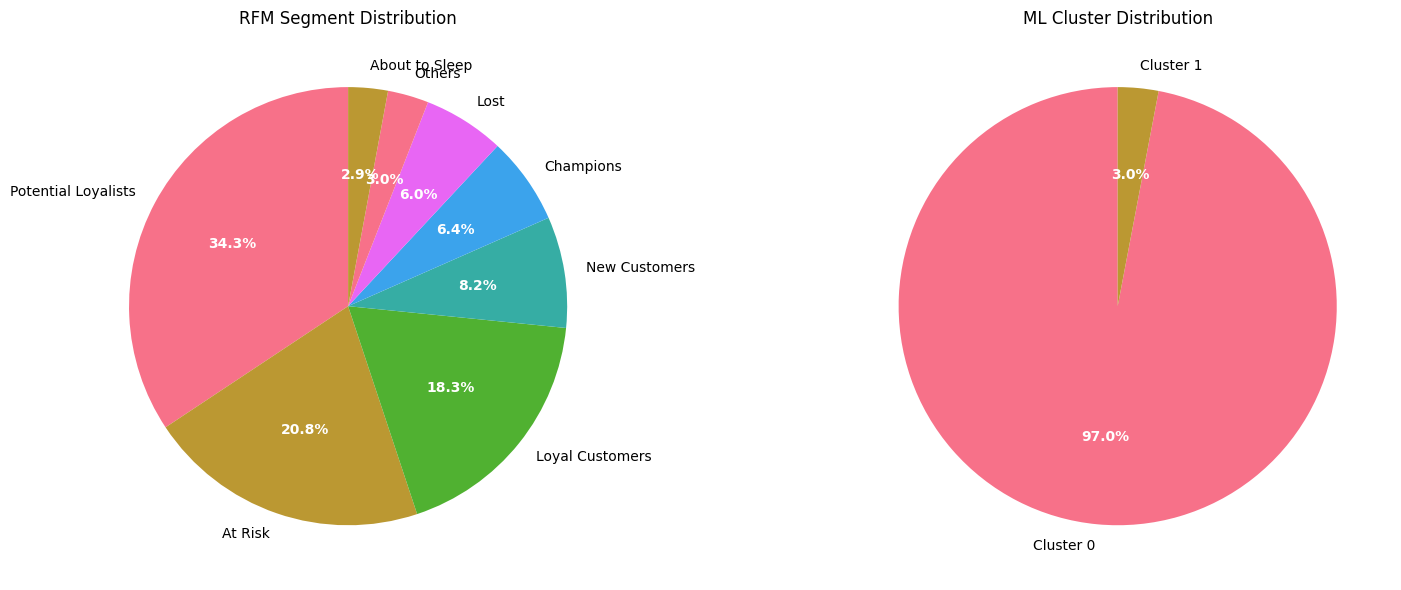

In [18]:
def compare_segmentation_methods(df):
    """
    Compare RFM segmentation with ML clustering
    """
    print("\nComparing RFM vs ML Clustering approaches...")
    
    # Cross-tabulation
    comparison = pd.crosstab(df['RFM_Segment'], df['ML_Cluster'], margins=True)
    print("Cross-tabulation of RFM Segments vs ML Clusters:")
    print(comparison)
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # RFM segments distribution
    rfm_counts = df['RFM_Segment'].value_counts()
    wedges, texts, autotexts = axes[0].pie(rfm_counts.values, labels=rfm_counts.index, 
                                          autopct='%1.1f%%', startangle=90)
    axes[0].set_title('RFM Segment Distribution')
    # Improve text readability
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_weight('bold')
    
    # ML clusters distribution
    ml_counts = df['ML_Cluster'].value_counts().sort_index()
    wedges2, texts2, autotexts2 = axes[1].pie(ml_counts.values, 
                                              labels=[f'Cluster {i}' for i in ml_counts.index], 
                                              autopct='%1.1f%%', startangle=90)
    axes[1].set_title('ML Cluster Distribution')
    # Improve text readability
    for autotext in autotexts2:
        autotext.set_color('white')
        autotext.set_weight('bold')
    
    plt.tight_layout()
    plt.show()
    
    return comparison

# Compare segmentation methods
segmentation_comparison = compare_segmentation_methods(customer_master)

In [20]:
def calculate_customer_lifetime_value(df):
    """
    Calculate estimated Customer Lifetime Value (CLV) for each segment
    """
    print("\nCalculating Customer Lifetime Value estimates...")
    
    # Simple CLV calculation: (Average Order Value × Purchase Frequency × Customer Lifespan)
    # We'll estimate lifespan based on recency and frequency patterns
    
    df_clv = df.copy()
    
    # Estimate customer lifespan in months
    # For customers with multiple orders, use their actual lifetime
    # For single-purchase customers, estimate based on their segment
    df_clv['estimated_lifespan_months'] = np.where(
        df_clv['customer_lifetime_days'] > 0,
        df_clv['customer_lifetime_days'] / 30,
        6  # Assume 6 months for new customers
    )
    
    # Calculate purchase frequency per month
    df_clv['monthly_frequency'] = np.where(
        df_clv['estimated_lifespan_months'] > 0,
        df_clv['frequency'] / df_clv['estimated_lifespan_months'],
        df_clv['frequency']  # For edge cases
    )
    
    # Estimate future lifespan based on recency (more recent = longer estimated future life)
    max_recency = df_clv['recency_days'].max()
    df_clv['estimated_future_months'] = np.where(
        df_clv['recency_days'] <= 30, 24,  # Recent customers: 24 months
        np.where(df_clv['recency_days'] <= 90, 12,  # Moderately recent: 12 months
                np.where(df_clv['recency_days'] <= 180, 6,  # Older: 6 months
                        3))  # Very old: 3 months
    )
    
    # Calculate CLV
    df_clv['estimated_clv'] = (
        df_clv['avg_order_value'] * 
        df_clv['monthly_frequency'] * 
        df_clv['estimated_future_months']
    ).round(2)
    
    return df_clv

def analyze_clv_by_segment(df):
    """
    Analyze CLV by different segments
    """
    print("\nCustomer Lifetime Value Analysis by Segment:")
    print("=" * 50)
    
    # CLV by ML Cluster
    clv_by_cluster = df.groupby('ML_Cluster').agg({
        'estimated_clv': ['mean', 'median', 'sum'],
        'ML_Cluster': 'count'
    }).round(2)
    
    clv_by_cluster.columns = ['Mean_CLV', 'Median_CLV', 'Total_CLV', 'Customer_Count']
    clv_by_cluster['CLV_per_Customer_Ratio'] = (clv_by_cluster['Total_CLV'] / 
                                               clv_by_cluster['Customer_Count']).round(2)
    
    print("\nCLV by ML Cluster:")
    print(clv_by_cluster)
    
    # CLV by RFM Segment
    clv_by_rfm = df.groupby('RFM_Segment').agg({
        'estimated_clv': ['mean', 'median', 'sum'],
        'RFM_Segment': 'count'
    }).round(2)
    
    clv_by_rfm.columns = ['Mean_CLV', 'Median_CLV', 'Total_CLV', 'Customer_Count']
    clv_by_rfm['CLV_per_Customer_Ratio'] = (clv_by_rfm['Total_CLV'] / 
                                           clv_by_rfm['Customer_Count']).round(2)
    
    print("\nCLV by RFM Segment:")
    print(clv_by_rfm.sort_values('Mean_CLV', ascending=False))
    
    return clv_by_cluster, clv_by_rfm

# Calculate CLV
customer_master_clv = calculate_customer_lifetime_value(customer_master)
clv_cluster_analysis, clv_rfm_analysis = analyze_clv_by_segment(customer_master_clv)


Calculating Customer Lifetime Value estimates...

Customer Lifetime Value Analysis by Segment:

CLV by ML Cluster:
            Mean_CLV  Median_CLV   Total_CLV  Customer_Count  \
ML_Cluster                                                     
0             137.01       76.76  13215669.8           96461   
1               0.00        0.00         0.0            2980   

            CLV_per_Customer_Ratio  
ML_Cluster                          
0                           137.01  
1                             0.00  

CLV by RFM Segment:
                     Mean_CLV  Median_CLV   Total_CLV  Customer_Count  \
RFM_Segment                                                             
Champions              411.18      302.40  2634411.04            6407   
Potential Loyalists    183.91      109.78  6277910.03           34135   
Loyal Customers        109.90       87.88  2000753.16           18206   
At Risk                 67.83       50.18  1401291.53           20660   
New Customers       

Attempting advanced visualizations...

Creating advanced visualizations...
DataFrame shape: (99441, 29)
Available columns: ['customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'total_spent', 'avg_order_value', 'std_order_value', 'total_orders', 'frequency', 'first_purchase', 'last_purchase', 'customer_lifetime_days', 'purchase_frequency_monthly', 'recency_days', 'unique_products', 'total_items', 'preferred_payment_type', 'avg_installments', 'total_payment_value', 'reviews_given', 'avg_review_score', 'reviews_with_comments', 'review_rate', 'ML_Cluster', 'RFM_Segment', 'estimated_lifespan_months', 'monthly_frequency', 'estimated_future_months', 'estimated_clv']
ML_Cluster unique values: [np.int32(0), np.int32(1)]
Creating CLV boxplot...
✓ CLV boxplot created
Creating RFM heatmap...
Pivot table shape: (2, 8)
✓ RFM heatmap created
Creating geographic distribution...
✓ Geographic distribution created
Creating frequency histogram...
✓ Frequency histogram crea

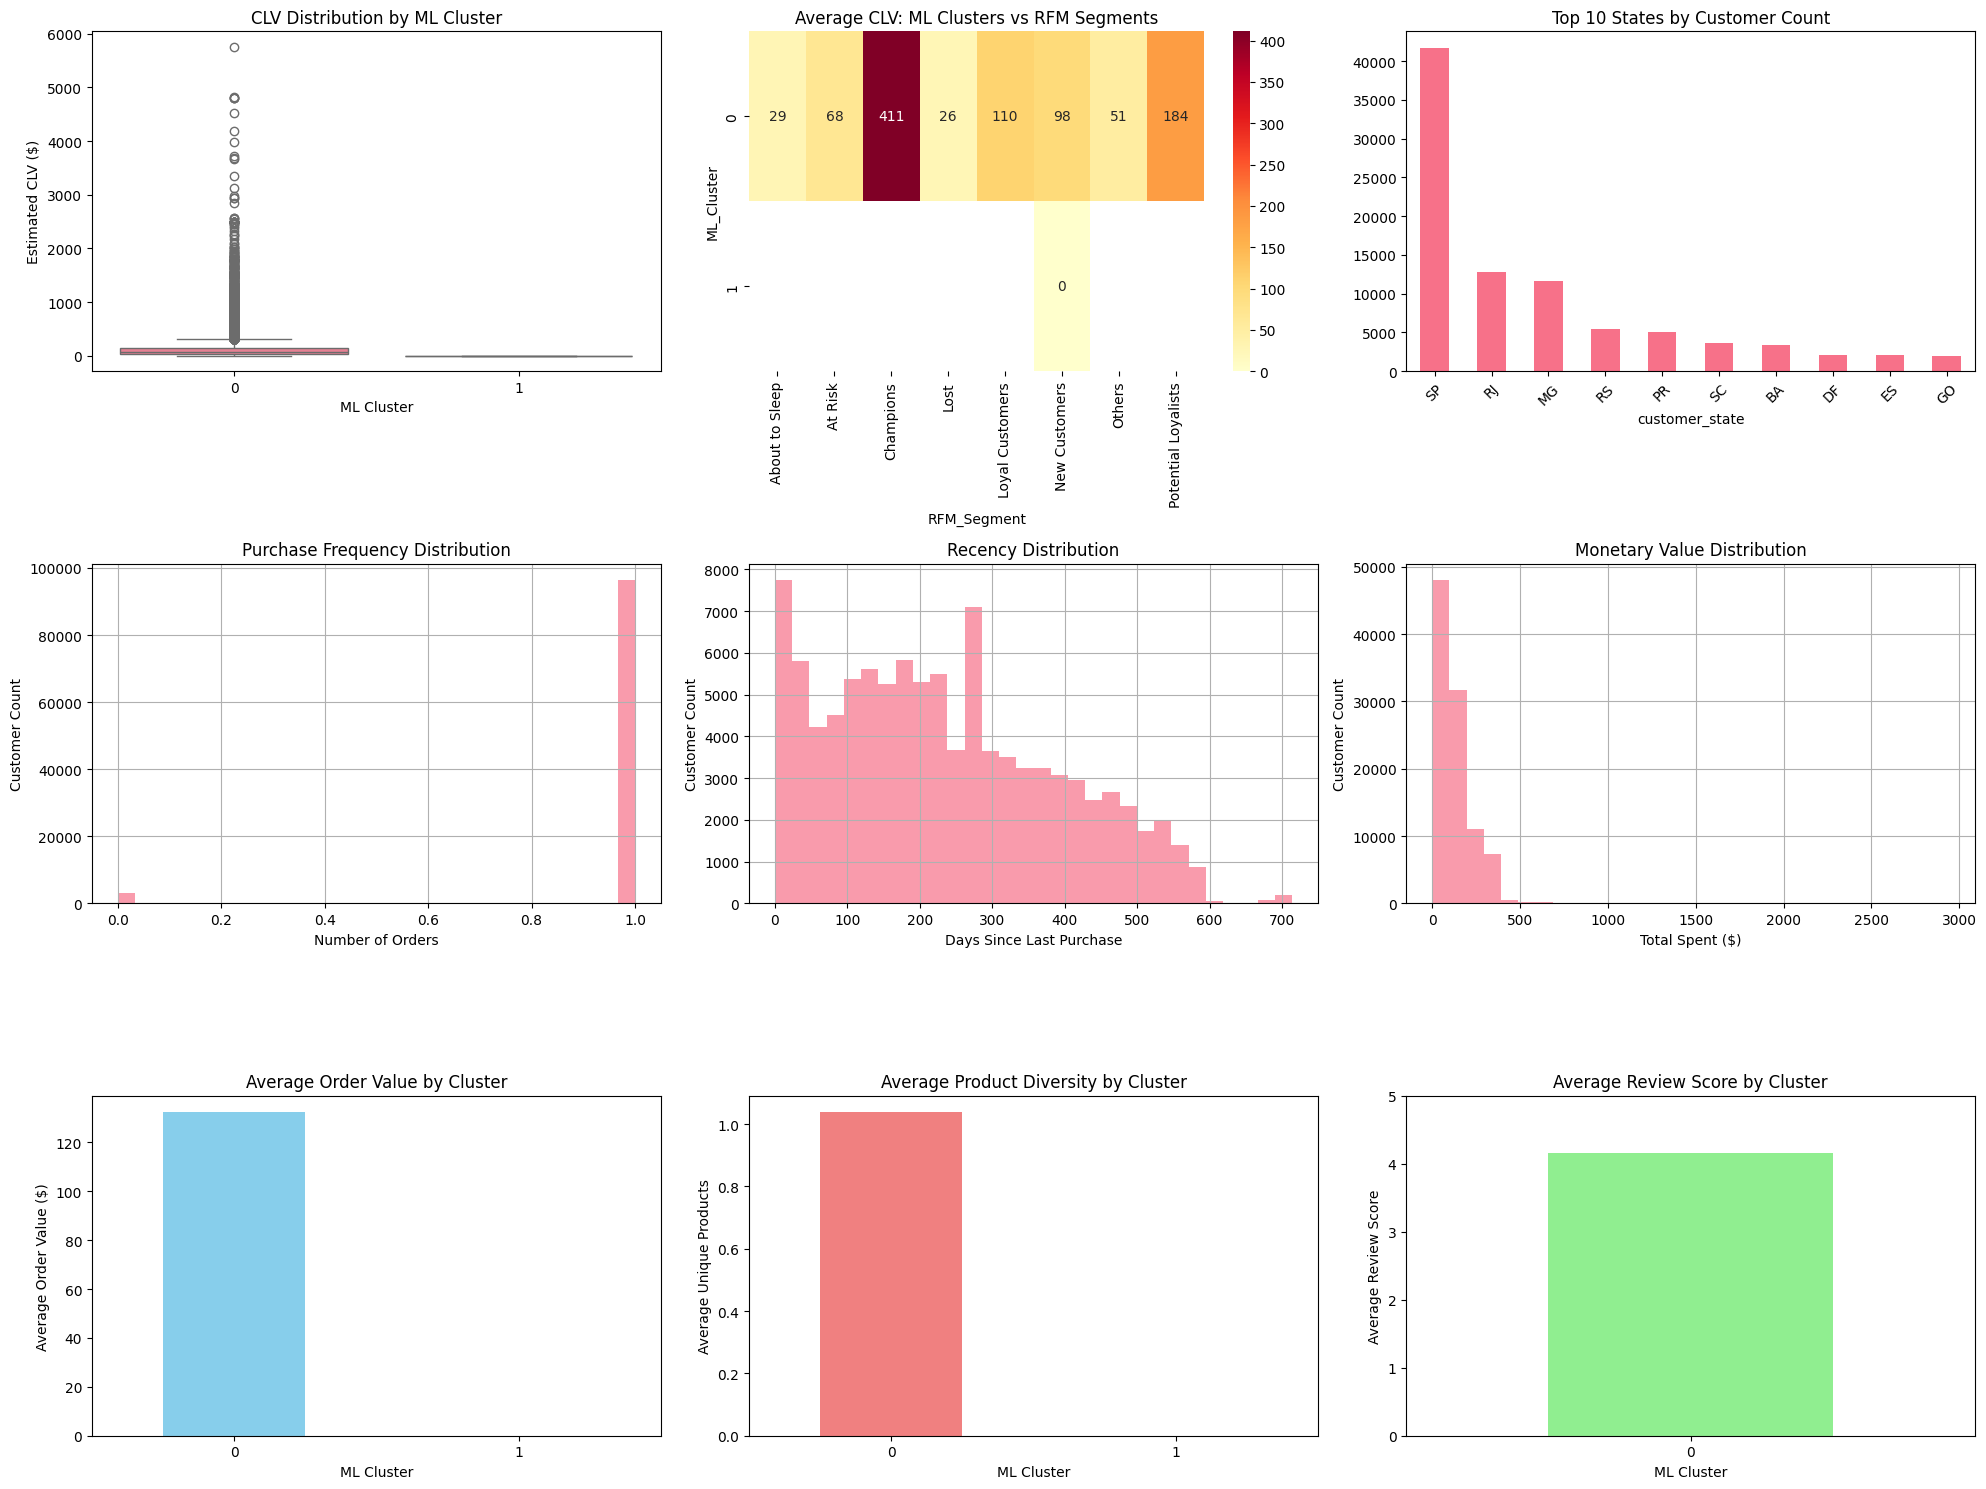

✓ All visualizations completed!


In [22]:
def create_advanced_visualizations(df):
    """
    Create advanced visualizations for customer segments
    """
    print("\nCreating advanced visualizations...")
    print(f"DataFrame shape: {df.shape}")
    print(f"Available columns: {list(df.columns)}")
    print(f"ML_Cluster unique values: {sorted(df['ML_Cluster'].unique())}")
    
    try:
        # Create a comprehensive dashboard-style visualization
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        axes = axes.flatten()  # Make it easier to work with
        
        # 1. CLV Distribution by Cluster
        try:
            print("Creating CLV boxplot...")
            # Use seaborn boxplot instead of pandas boxplot for better control
            sns.boxplot(data=df, x='ML_Cluster', y='estimated_clv', ax=axes[0])
            axes[0].set_title('CLV Distribution by ML Cluster')
            axes[0].set_xlabel('ML Cluster')
            axes[0].set_ylabel('Estimated CLV ($)')
            print("✓ CLV boxplot created")
        except Exception as e:
            print(f"Error creating CLV boxplot: {e}")
            axes[0].text(0.5, 0.5, f'CLV boxplot error:\n{str(e)}', 
                        ha='center', va='center', transform=axes[0].transAxes)
            axes[0].set_title('CLV Distribution by ML Cluster')
        
        # 2. RFM Heatmap
        try:
            print("Creating RFM heatmap...")
            rfm_pivot = df.pivot_table(values='estimated_clv', 
                                      index='ML_Cluster', 
                                      columns='RFM_Segment', 
                                      aggfunc='mean')
            print(f"Pivot table shape: {rfm_pivot.shape}")
            if not rfm_pivot.empty:
                sns.heatmap(rfm_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1])
                axes[1].set_title('Average CLV: ML Clusters vs RFM Segments')
            else:
                axes[1].text(0.5, 0.5, 'No data for heatmap', 
                            ha='center', va='center', transform=axes[1].transAxes)
                axes[1].set_title('Average CLV: ML Clusters vs RFM Segments')
            print("✓ RFM heatmap created")
        except Exception as e:
            print(f"Error creating RFM heatmap: {e}")
            axes[1].text(0.5, 0.5, f'Heatmap error:\n{str(e)}', 
                        ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title('Average CLV: ML Clusters vs RFM Segments')
        
        # 3. Customer Distribution by State (if available)
        try:
            print("Creating geographic distribution...")
            if 'customer_state' in df.columns:
                state_counts = df['customer_state'].value_counts().head(10)
                state_counts.plot(kind='bar', ax=axes[2])
                axes[2].set_title('Top 10 States by Customer Count')
                axes[2].tick_params(axis='x', rotation=45)
            else:
                axes[2].text(0.5, 0.5, 'State data not available', 
                            ha='center', va='center', transform=axes[2].transAxes)
                axes[2].set_title('Geographic Distribution')
            print("✓ Geographic distribution created")
        except Exception as e:
            print(f"Error creating geographic plot: {e}")
            axes[2].text(0.5, 0.5, f'Geographic error:\n{str(e)}', 
                        ha='center', va='center', transform=axes[2].transAxes)
            axes[2].set_title('Geographic Distribution')
        
        # 4. Purchase Frequency Distribution
        try:
            print("Creating frequency histogram...")
            df['frequency'].hist(bins=min(30, len(df)//10), alpha=0.7, ax=axes[3])
            axes[3].set_title('Purchase Frequency Distribution')
            axes[3].set_xlabel('Number of Orders')
            axes[3].set_ylabel('Customer Count')
            print("✓ Frequency histogram created")
        except Exception as e:
            print(f"Error creating frequency histogram: {e}")
            axes[3].text(0.5, 0.5, f'Frequency error:\n{str(e)}', 
                        ha='center', va='center', transform=axes[3].transAxes)
            axes[3].set_title('Purchase Frequency Distribution')
        
        # 5. Recency Distribution
        try:
            print("Creating recency histogram...")
            df['recency_days'].hist(bins=min(30, len(df)//10), alpha=0.7, ax=axes[4])
            axes[4].set_title('Recency Distribution')
            axes[4].set_xlabel('Days Since Last Purchase')
            axes[4].set_ylabel('Customer Count')
            print("✓ Recency histogram created")
        except Exception as e:
            print(f"Error creating recency histogram: {e}")
            axes[4].text(0.5, 0.5, f'Recency error:\n{str(e)}', 
                        ha='center', va='center', transform=axes[4].transAxes)
            axes[4].set_title('Recency Distribution')
        
        # 6. Monetary Distribution
        try:
            print("Creating monetary histogram...")
            df['total_spent'].hist(bins=min(30, len(df)//10), alpha=0.7, ax=axes[5])
            axes[5].set_title('Monetary Value Distribution')
            axes[5].set_xlabel('Total Spent ($)')
            axes[5].set_ylabel('Customer Count')
            print("✓ Monetary histogram created")
        except Exception as e:
            print(f"Error creating monetary histogram: {e}")
            axes[5].text(0.5, 0.5, f'Monetary error:\n{str(e)}', 
                        ha='center', va='center', transform=axes[5].transAxes)
            axes[5].set_title('Monetary Value Distribution')
        
        # 7. Average Order Value by Cluster
        try:
            print("Creating AOV by cluster...")
            cluster_aov = df.groupby('ML_Cluster')['avg_order_value'].mean()
            cluster_aov.plot(kind='bar', ax=axes[6], color='skyblue')
            axes[6].set_title('Average Order Value by Cluster')
            axes[6].set_xlabel('ML Cluster')
            axes[6].set_ylabel('Average Order Value ($)')
            axes[6].tick_params(axis='x', rotation=0)
            print("✓ AOV by cluster created")
        except Exception as e:
            print(f"Error creating AOV plot: {e}")
            axes[6].text(0.5, 0.5, f'AOV error:\n{str(e)}', 
                        ha='center', va='center', transform=axes[6].transAxes)
            axes[6].set_title('Average Order Value by Cluster')
        
        # 8. Product Diversity by Cluster
        try:
            print("Creating product diversity plot...")
            cluster_products = df.groupby('ML_Cluster')['unique_products'].mean()
            cluster_products.plot(kind='bar', ax=axes[7], color='lightcoral')
            axes[7].set_title('Average Product Diversity by Cluster')
            axes[7].set_xlabel('ML Cluster')
            axes[7].set_ylabel('Average Unique Products')
            axes[7].tick_params(axis='x', rotation=0)
            print("✓ Product diversity plot created")
        except Exception as e:
            print(f"Error creating product diversity plot: {e}")
            axes[7].text(0.5, 0.5, f'Product diversity error:\n{str(e)}', 
                        ha='center', va='center', transform=axes[7].transAxes)
            axes[7].set_title('Average Product Diversity by Cluster')
        
        # 9. Review Score by Cluster
        try:
            print("Creating review score plot...")
            if 'avg_review_score' in df.columns and df['avg_review_score'].sum() > 0:
                cluster_reviews = df[df['avg_review_score'] > 0].groupby('ML_Cluster')['avg_review_score'].mean()
                if not cluster_reviews.empty:
                    cluster_reviews.plot(kind='bar', ax=axes[8], color='lightgreen')
                    axes[8].set_title('Average Review Score by Cluster')
                    axes[8].set_xlabel('ML Cluster')
                    axes[8].set_ylabel('Average Review Score')
                    axes[8].set_ylim(0, 5)
                    axes[8].tick_params(axis='x', rotation=0)
                else:
                    axes[8].text(0.5, 0.5, 'No review data available', 
                                ha='center', va='center', transform=axes[8].transAxes)
                    axes[8].set_title('Review Score Analysis')
            else:
                axes[8].text(0.5, 0.5, 'Review data not available', 
                            ha='center', va='center', transform=axes[8].transAxes)
                axes[8].set_title('Review Score Analysis')
            print("✓ Review score plot created")
        except Exception as e:
            print(f"Error creating review score plot: {e}")
            axes[8].text(0.5, 0.5, f'Review error:\n{str(e)}', 
                        ha='center', va='center', transform=axes[8].transAxes)
            axes[8].set_title('Review Score Analysis')
        
        plt.tight_layout()
        plt.show()
        print("✓ All visualizations completed!")
        
    except Exception as e:
        print(f"Critical error in visualization function: {e}")
        # Create a simple fallback visualization
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        ax.text(0.5, 0.5, f'Visualization Error:\n{str(e)}\n\nData shape: {df.shape}', 
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title('Visualization Error')
        plt.show()

def create_simple_visualizations(df):
    """
    Create simple visualizations as fallback
    """
    print("\nCreating simple visualizations...")
    
    try:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # 1. Cluster distribution
        cluster_counts = df['ML_Cluster'].value_counts().sort_index()
        axes[0, 0].pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index], 
                      autopct='%1.1f%%')
        axes[0, 0].set_title('ML Cluster Distribution')
        
        # 2. RFM segment distribution
        rfm_counts = df['RFM_Segment'].value_counts()
        axes[0, 1].pie(rfm_counts.values[:5], labels=rfm_counts.index[:5], autopct='%1.1f%%')  # Top 5 only
        axes[0, 1].set_title('Top RFM Segments')
        
        # 3. CLV vs Cluster
        cluster_clv = df.groupby('ML_Cluster')['estimated_clv'].mean()
        axes[1, 0].bar(cluster_clv.index, cluster_clv.values)
        axes[1, 0].set_title('Average CLV by Cluster')
        axes[1, 0].set_xlabel('ML Cluster')
        axes[1, 0].set_ylabel('Average CLV ($)')
        
        # 4. Frequency vs CLV scatter
        axes[1, 1].scatter(df['frequency'], df['estimated_clv'], alpha=0.5, c=df['ML_Cluster'])
        axes[1, 1].set_title('Frequency vs CLV')
        axes[1, 1].set_xlabel('Purchase Frequency')
        axes[1, 1].set_ylabel('Estimated CLV ($)')
        
        plt.tight_layout()
        plt.show()
        print("✓ Simple visualizations completed!")
        
    except Exception as e:
        print(f"Error in simple visualizations: {e}")
        return False
    
    return True

# Create advanced visualizations with fallback
print("Attempting advanced visualizations...")
try:
    create_advanced_visualizations(customer_master_clv)
except Exception as e:
    print(f"Advanced visualizations failed: {e}")
    print("Falling back to simple visualizations...")
    if not create_simple_visualizations(customer_master_clv):
        print("All visualizations failed. Continuing with analysis...")

In [24]:
def save_segmentation_results(df, recommendations, clv_cluster, clv_rfm, output_folder='results/'):
    """
    Save segmentation results and recommendations
    """
    import os
    os.makedirs(output_folder, exist_ok=True)
    
    try:
        # Save customer master table with segments
        df.to_csv(f'{output_folder}customer_segments.csv')
        print(f"✓ Saved customer segments to {output_folder}customer_segments.csv")
        
        # Save business recommendations
        recommendations_df = []
        for cluster, rec in recommendations.items():
            row = {
                'cluster': cluster,
                'segment_name': rec['name'],
                'size': rec['size'],
                'percentage': rec['percentage'],
                **rec['characteristics'],
                'strategies': ' | '.join(rec['strategies'])
            }
            recommendations_df.append(row)
        
        recommendations_df = pd.DataFrame(recommendations_df)
        recommendations_df.to_csv(f'{output_folder}business_recommendations.csv', index=False)
        print(f"✓ Saved business recommendations to {output_folder}business_recommendations.csv")
        
        # Save CLV analysis
        clv_cluster.to_csv(f'{output_folder}clv_by_cluster.csv')
        clv_rfm.to_csv(f'{output_folder}clv_by_rfm_segment.csv')
        print(f"✓ Saved CLV analysis to {output_folder}clv_*.csv")
        
        # Save summary statistics
        summary_stats = {
            'total_customers': len(df),
            'total_estimated_clv': df['estimated_clv'].sum(),
            'average_clv': df['estimated_clv'].mean(),
            'median_clv': df['estimated_clv'].median(),
            'num_ml_clusters': df['ML_Cluster'].nunique(),
            'num_rfm_segments': df['RFM_Segment'].nunique(),
            'analysis_date': analysis_date.strftime('%Y-%m-%d')
        }
        
        summary_df = pd.DataFrame([summary_stats])
        summary_df.to_csv(f'{output_folder}segmentation_summary.csv', index=False)
        print(f"✓ Saved summary statistics to {output_folder}segmentation_summary.csv")
        
    except Exception as e:
        print(f"Error saving results: {e}")

# Save results
save_segmentation_results(customer_master_clv, business_recommendations, 
                         clv_cluster_analysis, clv_rfm_analysis)


✓ Saved customer segments to results/customer_segments.csv
✓ Saved business recommendations to results/business_recommendations.csv
✓ Saved CLV analysis to results/clv_*.csv
✓ Saved summary statistics to results/segmentation_summary.csv


In [25]:
def generate_final_insights(df, recommendations):
    """
    Generate final actionable insights and next steps
    """
    print("\n" + "="*70)
    print("FINAL INSIGHTS AND ACTIONABLE RECOMMENDATIONS")
    print("="*70)
    
    # Key metrics summary
    total_customers = len(df)
    total_clv = df['estimated_clv'].sum()
    avg_clv = df['estimated_clv'].mean()
    
    print(f"\n📊 KEY BUSINESS METRICS:")
    print(f"   • Total Customers Analyzed: {total_customers:,}")
    print(f"   • Total Estimated CLV: ${total_clv:,.2f}")
    print(f"   • Average CLV per Customer: ${avg_clv:.2f}")
    print(f"   • Number of Customer Segments: {df['ML_Cluster'].nunique()}")
    
    # Identify high-value segments
    cluster_clv = df.groupby('ML_Cluster')['estimated_clv'].mean().sort_values(ascending=False)
    print(f"\n💎 TOP VALUE SEGMENTS (by Average CLV):")
    for i, (cluster, clv) in enumerate(cluster_clv.head(3).items(), 1):
        cluster_size = len(df[df['ML_Cluster'] == cluster])
        percentage = (cluster_size / total_customers) * 100
        print(f"   {i}. Cluster {cluster}: ${clv:.2f} avg CLV ({cluster_size:,} customers, {percentage:.1f}%)")
    
    # Risk analysis
    at_risk_customers = df[df['recency_days'] > df['recency_days'].quantile(0.8)]
    print(f"\n⚠️  RISK ANALYSIS:")
    print(f"   • Customers at risk (high recency): {len(at_risk_customers):,} ({len(at_risk_customers)/total_customers*100:.1f}%)")
    print(f"   • Potential revenue at risk: ${at_risk_customers['estimated_clv'].sum():.2f}")
    
    # Opportunity analysis
    new_customers = df[df['frequency'] == 1]
    print(f"\n🎯 GROWTH OPPORTUNITIES:")
    print(f"   • New customers (single purchase): {len(new_customers):,} ({len(new_customers)/total_customers*100:.1f}%)")
    print(f"   • Potential value from retention: ${new_customers['estimated_clv'].sum():.2f}")
    
    # Priority actions
    print(f"\n🚀 PRIORITY ACTIONS:")
    print(f"   1. Focus on top {cluster_clv.head(2).index.tolist()} clusters for VIP programs")
    print(f"   2. Implement win-back campaigns for {len(at_risk_customers):,} at-risk customers")
    print(f"   3. Create onboarding sequences for {len(new_customers):,} new customers")
    print(f"   4. Develop targeted strategies for each of the {df['ML_Cluster'].nunique()} segments")
    
    return {
        'total_customers': total_customers,
        'total_clv': total_clv,
        'avg_clv': avg_clv,
        'top_segments': cluster_clv.head(3).to_dict(),
        'at_risk_count': len(at_risk_customers),
        'new_customer_count': len(new_customers)
    }

# Generate final insights
final_insights = generate_final_insights(customer_master_clv, business_recommendations)

print("\n" + "="*70)
print("CUSTOMER SEGMENTATION ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*70)
print("📁 Output files saved in 'results/' folder:")
print("   • customer_segments.csv - Complete customer data with segments")
print("   • business_recommendations.csv - Actionable strategies per segment")
print("   • clv_by_cluster.csv & clv_by_rfm_segment.csv - CLV analysis")
print("   • segmentation_summary.csv - High-level summary statistics")
print("\n🔄 Next Steps:")
print("   • Review and validate segment characteristics")
print("   • Implement A/B testing for recommended strategies")
print("   • Set up monitoring dashboards for segment performance")
print("   • Schedule regular re-segmentation (quarterly recommended)")
print("="*70)


FINAL INSIGHTS AND ACTIONABLE RECOMMENDATIONS

📊 KEY BUSINESS METRICS:
   • Total Customers Analyzed: 99,441
   • Total Estimated CLV: $13,215,669.80
   • Average CLV per Customer: $132.90
   • Number of Customer Segments: 2

💎 TOP VALUE SEGMENTS (by Average CLV):
   1. Cluster 0: $137.01 avg CLV (96,461 customers, 97.0%)
   2. Cluster 1: $0.00 avg CLV (2,980 customers, 3.0%)

⚠️  RISK ANALYSIS:
   • Customers at risk (high recency): 19,859 (20.0%)
   • Potential revenue at risk: $1295890.18

🎯 GROWTH OPPORTUNITIES:
   • New customers (single purchase): 96,461 (97.0%)
   • Potential value from retention: $13215669.80

🚀 PRIORITY ACTIONS:
   1. Focus on top [0, 1] clusters for VIP programs
   2. Implement win-back campaigns for 19,859 at-risk customers
   3. Create onboarding sequences for 96,461 new customers
   4. Develop targeted strategies for each of the 2 segments

CUSTOMER SEGMENTATION ANALYSIS COMPLETED SUCCESSFULLY!
📁 Output files saved in 'results/' folder:
   • customer_segm